In [1]:
import random
import numpy as np
import torch 
from torch_geometric.data import HeteroData
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import MetaPath2Vec

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from tqdm.notebook import tqdm

In [2]:
dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [3]:
data['paper'].x.size(), data['paper'].x

(torch.Size([736389, 128]),
 tensor([[-0.0954,  0.0408, -0.2109,  ...,  0.0616, -0.0277, -0.1338],
         [-0.1510, -0.1073, -0.2220,  ...,  0.3458, -0.0277, -0.2185],
         [-0.1148, -0.1760, -0.2606,  ...,  0.1731, -0.1564, -0.2780],
         ...,
         [ 0.0228, -0.0865,  0.0981,  ..., -0.0547, -0.2077, -0.2305],
         [-0.2891, -0.2029, -0.1525,  ...,  0.1042,  0.2041, -0.3528],
         [-0.0890, -0.0348, -0.2642,  ...,  0.2601, -0.0875, -0.5171]]))

In [4]:
len(data['paper'].x)

736389

In [5]:
# for _ in range(10_000):
#     random_idx = random.randint(0, len(data['paper'].x)-1)
#     print(random_idx)
#     break

In [6]:
# x = data['paper'].x
# x = x[:10000]

### Embedding for MovieLens Dataset

In [7]:
from neo4_connection import USER, URL, PWD
from neo4j import GraphDatabase
import pandas as pd

In [8]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

### Encode all nodes

In [9]:
u_query = """
MATCH (u:User)
RETURN u.userId AS userId
"""

m_query = """
MATCH (m:Movie)
RETURN m.movieId AS movieId
"""

p_query = """
MATCH (p:Person)
RETURN p.name AS person
"""

g_query = """
MATCH (g:Genre)
RETURN g.name as genre
"""

user = fetch_data(u_query)
movie = fetch_data(m_query)
person = fetch_data(p_query)
genre = fetch_data(g_query)

print('User:', len(user), 'Movies:', len(movie), 'Persons:', len(person), 'Genres:', len(g_query))

u_encoder, m_encoder, p_encoder, g_encoder = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()

u_encoder.fit(user['userId'])
m_encoder.fit(movie['movieId'])
p_encoder.fit(person['person'])
g_encoder.fit(genre['genre'])


User: 671 Movies: 9125 Persons: 19047 Genres: 40


LabelEncoder()

### Create edge dataframes

In [10]:
movie_in_genre_query = """
MATCH (m:Movie) -[:IN_GENRE]-> (g:Genre)
RETURN m.movieId as movieId, g.name AS genre
"""

movie_in_genre_df = fetch_data(movie_in_genre_query)
movie_in_genre_df['movieId'] = m_encoder.transform(movie_in_genre_df['movieId'])
movie_in_genre_df['genre'] = g_encoder.transform(movie_in_genre_df['genre'])

print('DF length:', len(movie_in_genre_df))
movie_in_genre_df.head()

DF length: 20340


,movieId,genre
0,8676,2
1,8703,2
2,8650,2
3,8649,2
4,8618,2


In [11]:
user_likes_movie_query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
WHERE r.rating >= 4 
RETURN u.userId AS userId, m.movieId AS movieId
"""

user_likes_movie_df = fetch_data(user_likes_movie_query)
user_likes_movie_df['userId'] = u_encoder.transform(user_likes_movie_df['userId'])
user_likes_movie_df['movieId'] = m_encoder.transform(user_likes_movie_df['movieId'])

print('DF length:', len(user_likes_movie_df))
user_likes_movie_df.head()

DF length: 51568


,userId,movieId
0,0,1515
1,0,1665
2,0,931
3,1,233
4,1,225


In [12]:
person_involvedIn_movie_query = """
MATCH (p:Person) -[]-> (m:Movie)
RETURN p.name AS person, m.movieId AS movieId
"""

person_involvedIn_movie_df = fetch_data(person_involvedIn_movie_query)
person_involvedIn_movie_df['person'] = p_encoder.transform(person_involvedIn_movie_df['person'])
person_involvedIn_movie_df['movieId'] = m_encoder.transform(person_involvedIn_movie_df['movieId'])

print('DF length:', len(person_involvedIn_movie_df))
person_involvedIn_movie_df.head()

DF length: 45917


,person,movieId
0,5994,6119
1,9699,6119
2,11114,4934
3,11114,5102
4,11114,5073


### Create edge indecies

In [13]:
movie_in_genre_edges = torch.Tensor(movie_in_genre_df.values).to(torch.long).swapaxes(1, 0)
user_likes_movie_edges = torch.Tensor(user_likes_movie_df.values).to(torch.long).swapaxes(1, 0)
person_involvedIn_movie_edges = torch.Tensor(person_involvedIn_movie_df.values).to(torch.long).swapaxes(1, 0)

movie_in_genre_edges.size(), user_likes_movie_edges.size(), person_involvedIn_movie_edges.size()

(torch.Size([2, 20340]), torch.Size([2, 51568]), torch.Size([2, 45917]))

In [14]:
def revert_edges(edges:torch.Tensor) -> torch.Tensor:
    """ """
    assert edges.size(0) == 2
    return torch.Tensor(np.array([edges[1].numpy(), edges[0].numpy()])).to(torch.long)

genre_belongsTo_movie_edges = revert_edges(movie_in_genre_edges)
movie_likedBy_user_edges = revert_edges(user_likes_movie_edges)

In [15]:
movie_in_genre_edges.size(), movie_in_genre_edges

(torch.Size([2, 20340]),
 tensor([[8676, 8703, 8650,  ..., 8784, 8732, 7724],
         [   2,    2,    2,  ...,    0,    0,    0]]))

In [16]:
genre_belongsTo_movie_edges.size(), genre_belongsTo_movie_edges

(torch.Size([2, 20340]),
 tensor([[   2,    2,    2,  ...,    0,    0,    0],
         [8676, 8703, 8650,  ..., 8784, 8732, 7724]]))

In [34]:
metapath = [
    ('movie', 'in_genre', 'genre'),
    ('user', 'liked', 'movie'),
    ('genre', 'belongs_to', 'movie'),
    ('movie', 'liked_by', 'user')
    # ('person', 'involved_in', 'movie')
]

edge_index_dict = {
    ('movie', 'in_genre', 'genre'): movie_in_genre_edges,
    ('user', 'liked', 'movie'): user_likes_movie_edges,
    ('genre', 'belongs_to', 'movie'): genre_belongsTo_movie_edges,
    ('movie', 'liked_by', 'user'): movie_likedBy_user_edges
}
edge_index_dict

{('movie',
  'in_genre',
  'genre'): tensor([[8676, 8703, 8650,  ..., 8784, 8732, 7724],
         [   2,    2,    2,  ...,    0,    0,    0]]),
 ('user',
  'liked',
  'movie'): tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1515, 1665,  931,  ..., 3812, 3000, 3213]]),
 ('genre',
  'belongs_to',
  'movie'): tensor([[   2,    2,    2,  ...,    0,    0,    0],
         [8676, 8703, 8650,  ..., 8784, 8732, 7724]]),
 ('movie',
  'liked_by',
  'user'): tensor([[1515, 1665,  931,  ..., 3812, 3000, 3213],
         [   0,    0,    0,  ...,  670,  670,  670]])}

In [18]:
# edge_index_dict = {
#     ('movie', 'in_genre', 'genre'): utils.to_undirected(movie_in_genre_edges),
#     ('user', 'liked', 'movie'): utils.to_undirected(user_likes_movie_edges)
#     # ('person', 'involved_in', 'movie'): utils.to_undirected(person_involvedIn_movie_edges)
# }
# edge_index_dict

In [35]:
model = MetaPath2Vec(
    edge_index_dict=edge_index_dict,
    embedding_dim=128,
    metapath=metapath,
    walk_length=4,
    context_size=4,
    walks_per_node=1,
    num_negative_samples=4,
    sparse=True
)

In [36]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=8)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.025)

In [37]:
for i, (pos_rw, neg_rw) in enumerate(loader):
    if i == 10: break
    print(i, pos_rw.shape, neg_rw.shape)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 186, in _sample
    return self._pos_sample(batch), self._neg_sample(batch)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 150, in _pos_sample
    batch = sample(adj, batch, num_neighbors=1,
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 239, in sample
    rowcount[mask] = src.storage.rowcount()[subset[mask]]
IndexError: index 1004 is out of bounds for dimension 0 with size 20


In [ ]:
print(pos_rw[0], neg_rw[0])

tensor([11318,     5, 11631,     3, 10259,     5, 10138,     8, 11187,     1]) tensor([11318,  3747, 13711,  8148,  9722,   434, 12770,  6066, 15680,  4422])


In [ ]:
def train(model, epoch, log_steps=100, eval_steps=2000):
    model.train()
    global loss
    total_loss = 0
    for i, (pos_rw, neg_rw) in tqdm(enumerate(loader)):
      optimizer.zero_grad()
      loss = model.loss(pos_rw, neg_rw)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

In [ ]:
epoch_loss = []
for epoch in range(1, 11):
    train(model,epoch)
    print(f"epoch: {epoch}, loss: {loss}")
    epoch_loss.append(loss)

0it [00:00, ?it/s]

epoch: 1, loss: 1.0597676038742065


0it [00:00, ?it/s]

epoch: 2, loss: 0.7792677879333496


0it [00:00, ?it/s]

epoch: 3, loss: 0.7412306070327759


0it [00:00, ?it/s]

epoch: 4, loss: 0.7266536355018616


0it [00:00, ?it/s]

epoch: 5, loss: 0.729417622089386


0it [00:00, ?it/s]

IndexError: Caught IndexError in DataLoader worker process 7.
Original Traceback (most recent call last):
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 186, in _sample
    return self._pos_sample(batch), self._neg_sample(batch)
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 150, in _pos_sample
    batch = sample(adj, batch, num_neighbors=1,
  File "c:\Users\roman\OneDrive - OST\2022_HS\VP_1_RecommenderSystem\.venv\lib\site-packages\torch_geometric\nn\models\metapath2vec.py", line 239, in sample
    rowcount[mask] = src.storage.rowcount()[subset[mask]]
IndexError: index 9123 is out of bounds for dimension 0 with size 9123


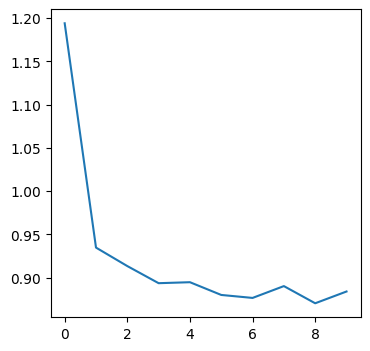

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4,4))
plt.plot([loss.item() for loss in epoch_loss])
plt.show()

In [ ]:
model.eval()
z_movie = model('movie')
z_user = model('user')
z_genre = model('genre')
z_person = model('person')

z_movie.size(), z_user.size(), z_genre.size(), z_person.size(),

(torch.Size([9125, 64]),
 torch.Size([671, 64]),
 torch.Size([20, 64]),
 torch.Size([19014, 64]))

In [ ]:
z_all = torch.concat([z_genre, z_movie, z_movie, z_person], dim=0).detach().numpy()
type(z_all), z_all.shape

(numpy.ndarray, (37284, 64))

In [ ]:
z_all_reduced = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(z_movie.detach().numpy())
z_all_reduced.shape

(9125, 2)

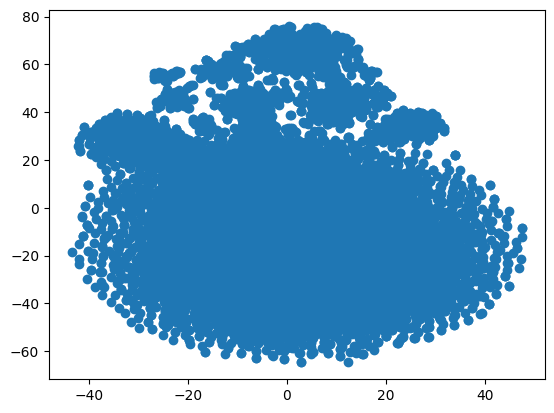

In [ ]:
plt.scatter(x=z_all_reduced[:,0], y=z_all_reduced[:,1])
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(z_user_reduced, c='r', label='User')
plt.scatter(z_user_reduced, c='g', label='Movies')
plt.scatter(z_genre_reduced, c='b', label='Genre')
plt.scatter(z_person_reduced, c='y', label='Person')


In [ ]:
model.eval()
z = model('user')
z.size()

torch.Size([671, 64])

In [ ]:
device = 'cpu'

def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data['author'].y_index.to(device))
    y = data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)


for epoch in range(1, 6):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

In [ ]:
movie_in_genre = np.unique(df[['movieId', 'genre']].values, axis=0)
movie_in_genre = torch.Tensor(movie_in_genre).to(torch.long).swapaxes(1, 0)

# genre_belongsTo_movie = np.unique(df[['genre', 'movieId']].values, axis=0)
genre_belongsTo_movie = torch.Tensor(np.array([movie_in_genre[1].numpy(), movie_in_genre[0].numpy()])).to(torch.long)


actor_actedIn_movie = np.unique(df[['movieId', 'actor']].values, axis=0, )
actor_actedIn_movie = torch.Tensor(actor_actedIn_movie).to(torch.long).swapaxes(1, 0)

# movie_hosted_actor = np.unique(df[['actor', 'movieId']].values, axis=0)
movie_hosted_actor = torch.Tensor(np.array([actor_actedIn_movie[1].numpy(), actor_actedIn_movie[0].numpy()])).to(torch.long)


print(movie_in_genre.size(), genre_belongsTo_movie.size())
print(actor_actedIn_movie.size(), movie_hosted_actor.size())

torch.Size([2, 20270]) torch.Size([2, 20270])
torch.Size([2, 35909]) torch.Size([2, 35909])


In [ ]:
# np.array([movie_in_genre[1].numpy(), movie_in_genre[0].numpy()])

array([[   2,    3,    4, ...,   16,    7,    5],
       [   0,    0,    0, ..., 9081, 9082, 9083]], dtype=int64)

In [ ]:
metapath = [
    ('movie', 'in_genre', 'genre'),
    ('genre', 'belongs_to', 'movie'),
    ('actor', 'acted_in', 'movie'),
    ('movie', 'hosted', 'actor')
]

In [ ]:
edge_index_dict = {
    ('movie', 'in_genre', 'genre'): movie_in_genre,
    ('genre', 'belongs_to', 'movie'): genre_belongsTo_movie,
    ('actor', 'acted_in', 'movie'): actor_actedIn_movie,
    ('movie', 'hosted', 'actor'): movie_hosted_actor}
edge_index_dict

{('movie',
  'in_genre',
  'genre'): tensor([[   0,    0,    0,  ..., 9081, 9082, 9083],
         [   2,    3,    4,  ...,   16,    7,    5]]),
 ('genre',
  'belongs_to',
  'movie'): tensor([[   2,    3,    4,  ...,   16,    7,    5],
         [   0,    0,    0,  ..., 9081, 9082, 9083]]),
 ('actor',
  'acted_in',
  'movie'): tensor([[    0,     0,     0,  ...,  9083,  9083,  9083],
         [ 3744,  6943, 14286,  ...,  5861,  8765, 11072]]),
 ('movie',
  'hosted',
  'actor'): tensor([[ 3744,  6943, 14286,  ...,  5861,  8765, 11072],
         [    0,     0,     0,  ...,  9083,  9083,  9083]])}

In [ ]:
from torch_geometric.nn import MetaPath2Vec

In [ ]:
model = MetaPath2Vec(
    edge_index_dict=edge_index_dict,
    embedding_dim=64,
    metapath=metapath,
    walk_length=5,
    context_size=5,
    walks_per_node=1,
    num_negative_samples=5,
    sparse=True
)

AttributeError: The 'walk_length' is longer than the given 'metapath', but the 'metapath' does not denote a cycle

In [ ]:
# model = MetaPath2Vec(edge_index_dict=edge_index_dict, 
#     embedding_dim=128,
#     metapath=metapath,
#     walk_length=100, 
#     context_size=10, walks_per_node=1, num_negative_samples=5, sparse=True).to('cpu')

In [ ]:
loader = model.loader(batch_size=128, shuffle=True)

In [ ]:
for i, (pos_rw, neg_rw) in enumerate(loader):
    if i == 10: break
    print(i, pos_rw.shape, neg_rw.shape)

0 torch.Size([2560, 4]) torch.Size([10240, 4])
1 torch.Size([2560, 4]) torch.Size([10240, 4])
2 torch.Size([2560, 4]) torch.Size([10240, 4])
3 torch.Size([2560, 4]) torch.Size([10240, 4])
4 torch.Size([2560, 4]) torch.Size([10240, 4])
5 torch.Size([2560, 4]) torch.Size([10240, 4])
6 torch.Size([2560, 4]) torch.Size([10240, 4])
7 torch.Size([2560, 4]) torch.Size([10240, 4])
8 torch.Size([2560, 4]) torch.Size([10240, 4])
9 torch.Size([2560, 4]) torch.Size([10240, 4])


In [ ]:
print(pos_rw[0], neg_rw[0])

tensor([14955,  9100, 15944, 22912]) tensor([14955,  9092, 18249, 11829])


In [ ]:
actor_encoder.inverse_transform([9092])

array(['Lou Rawls'], dtype=object)

In [ ]:
df['actor'].max(), df['movieId'].max(), df['genre'].max(),

(15439, 9083, 19)

In [ ]:
edge_index_dict[('movie',
  'in_genre',
  'genre')][0].max()

tensor(9083)